# Explainable AI (XAI)

# Preparation
## Environmental Settings

In [1]:
# Download the dataset
!gdown --id '19CzXudqN58R3D-1G8KeFWk8UDQwlb8is' --output food-11.zip
!unzip food-11.zip

串流輸出內容已截斷至最後 5000 行。
  inflating: food-11/training/8_427.jpg  
  inflating: food-11/training/2_849.jpg  
  inflating: food-11/training/4_165.jpg  
  inflating: food-11/training/5_376.jpg  
  inflating: food-11/training/2_691.jpg  
  inflating: food-11/training/0_541.jpg  
  inflating: food-11/training/3_482.jpg  
  inflating: food-11/training/0_227.jpg  
  inflating: food-11/training/5_410.jpg  
  inflating: food-11/training/4_603.jpg  
  inflating: food-11/training/8_341.jpg  
  inflating: food-11/training/5_1154.jpg  
  inflating: food-11/training/9_37.jpg  
  inflating: food-11/training/9_152.jpg  
  inflating: food-11/training/5_438.jpg  
  inflating: food-11/training/9_1287.jpg  
  inflating: food-11/training/8_369.jpg  
  inflating: food-11/training/2_1455.jpg  
  inflating: food-11/training/10_247.jpg  
  inflating: food-11/training/7_32.jpg  
  inflating: food-11/training/10_521.jpg  
  inflating: food-11/training/2_1333.jpg  
  inflating: food-11/training/2_861.jpg  
  inflati

In [2]:
# download the pretrained model weight
# !gdown --id '1y0pcR27Hlf0cjMJm17bNe31opDlAUbFw' --output checkpoint.pth # my model
!gdown --id '1CShZHsO8oAZwxQkMe7jRtEgSNb2w_OZu' --output checkpoint.pth # model from TA

Downloading...
From: https://drive.google.com/uc?id=1CShZHsO8oAZwxQkMe7jRtEgSNb2w_OZu
To: /content/checkpoint.pth
170MB [00:03, 44.5MB/s]


In [3]:
# install the lime package
!pip install lime==0.1.1.37

## Import libraries

In [4]:
import argparse
import torch
import torch.nn as nn
from torch.utils.data import Dataset
import torchvision.transforms as transforms
from PIL import Image
import os
import matplotlib.pyplot as plt
from lime import lime_image
from skimage.segmentation import slic
import numpy as np

## Argument parsing

In [5]:
args = {
      'ckptpath': './checkpoint.pth',
      'dataset_dir': './food-11/'
}
args = argparse.Namespace(**args)

## Build the CNN model and load the checkpoint

In [7]:
# build the CNN model
class Classifier(nn.Module):
  def __init__(self):
    super(Classifier, self).__init__()

    def building_block(indim, outdim):
      return [
        nn.Conv2d(indim, outdim, 3, 1, 1),
        nn.BatchNorm2d(outdim),
        nn.ReLU(),
      ]
    def stack_blocks(indim, outdim, block_num):
      layers = building_block(indim, outdim)
      for i in range(block_num - 1):
        layers += building_block(outdim, outdim)
      layers.append(nn.MaxPool2d(2, 2, 0))
      return layers

    cnn_list = []
    cnn_list += stack_blocks(3, 128, 3)
    cnn_list += stack_blocks(128, 128, 3)
    cnn_list += stack_blocks(128, 256, 3)
    cnn_list += stack_blocks(256, 512, 1)
    cnn_list += stack_blocks(512, 512, 1)
    self.cnn = nn.Sequential( * cnn_list)

    dnn_list = [
      nn.Linear(512 * 4 * 4, 1024),
      nn.ReLU(),
      nn.Dropout(p = 0.3),
      nn.Linear(1024, 11),
    ]
    self.fc = nn.Sequential( * dnn_list)

  def forward(self, x):
    out = self.cnn(x)
    out = out.reshape(out.size()[0], -1)
    return self.fc(out)

In [8]:
model = Classifier().cuda()
checkpoint = torch.load(args.ckptpath)
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

## Define the Dataset

In [9]:
class FoodDataset(Dataset):
  def __init__(self, paths, labels, mode):
    """
      path (str): the path of the data folder. i.e. "training", "validation", or "testing".
      labels (list): training or validation labels.
      mode (str): "train" or "eval".
    """
    self.paths = paths
    self.labels = labels

    # define transformers
    train_transform = transforms.Compose([
      transforms.Resize(size=(128, 128)),
      transforms.RandomHorizontalFlip(),
      transforms.RandomRotation(15),
      transforms.ToTensor(),
    ])
    eval_transform = transforms.Compose([
      transforms.Resize(size=(128, 128)),
      transforms.ToTensor(),
    ])
    self.transform = train_transform if model == 'train' else eval_transform

  def __len__(self):
    return len(self.paths)
  
  def __getitem__(self, index):
    X = Image.open(self.paths[index])
    X = self.transform(X)
    Y = self.labels[index]
    return X, Y
  
  def getbatch(self, indices):
    """
      Get the batch of images and labels based on the indices.
    """
    images = []
    labels = []
    for index in indices:
      image, label = self.__getitem__(index)
      images.append(image)
      labels.append(label)
    return torch.stack(images), torch.tensor(labels)

def get_paths_labels(path):
  """
    Get the paths and labels of all the images in the specified path.
  """
  img_names = sorted(os.listdir(path))
  img_paths = []
  labels = []
  
  for name in img_names:
    img_paths.append(os.path.join(path, name))
    labels.append(int(name.split('_')[0]))
  return img_paths, labels

train_paths, train_labels = get_paths_labels(os.path.join(args.dataset_dir, 'training'))

train_dataset = FoodDataset(train_paths, train_labels, mode='eval')

# Task 1: Saliency map
- Input an image into the model and compute the label loss.
- There are three things related to the loss:
    - the image itself,
    - the model parameter,
    - and the label
- In general, we train a model by **computing the gradient of loss to model parameter** in the backward pass. That is, by adjusting the model parameters to fit the image and label.
- Mathmathematically, the image itself is a **continuous tensor**, so we can **compute the gradient of loss to image**. This means that when fixing the model parameters and label, **what's the change by slightly tuning one pixel of the image**.
- Since each pixel of the image has its gradient, the larger gradient, the more important of the pixel while the model is making a decision.
- How to implement it?
    - By default, PyTorch computes **the gradient of the loss to model parameter**. We just need one more line of code to tell PyTorch **image** requires gradient as well.

In [10]:
def normalize(image):
  return (image - image.min()) / (image.max() - image.min())

def compute_saliency_map(x, y, model):
  # check if the GPU is available
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  
  model.eval() # set the model as evaluation mode
  
  # push x and y to "GPU"
  x = x.to(device)
  y = y.to(device)

  # set x to be required gradient
  # to compute the gradient of loss on image
  x.requires_grad_()

  # forward pass
  y_pred = model(x)

  # loss
  loss_func = torch.nn.CrossEntropyLoss()
  loss = loss_func(y_pred, y)

  # backward pass
  loss.backward() # compute the gradient of loss on image
  
  saliencies = x.grad.abs().detach().cpu()
  # the gradient scale might differ greatly in every image
  # ex: the gradient of the 1st image is in 100~1000; while the 2nd is in 0.001~0.0001
  # if we use the same color scale to draw every saliency map,
  # chances are that the 1st map is very bright, while the 2nd is very dark
  # Hence, normalization is needed to "observe the relationship in a single saliency map" 

  saliencies = torch.stack([normalize(item) for item in saliencies])
  return saliencies

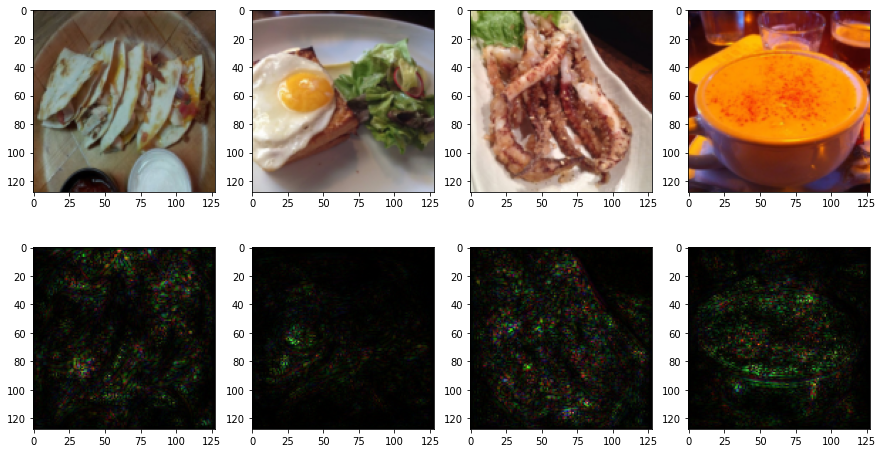

In [11]:
# assign indices of the to-be-visualized images
img_indices = [83, 4218, 4707, 8598]
images, labels = train_dataset.getbatch(img_indices)
saliencies = compute_saliency_map(images, labels, model)

# plot the result
fig, axs = plt.subplots(2, len(img_indices), figsize=(15, 8))
for row, target in enumerate([images, saliencies]):
  for column, img in enumerate(target):
    axs[row][column].imshow(img.permute(1, 2, 0).numpy())
plt.show()
plt.close()

# Task 2: Filter Explanation
- We want to know what a filter can recognize by doing the following two things:
    - Filter activation: sample some images to see which part of an image can activate the filter
    - Filter visualization: what kind of image can activate the filter the most
- In PyTorch, there is a method called `hook` providing the ability to record the activation map a layer.

In [12]:
model

Classifier(
  (cnn): Sequential(
    (0): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU()
    (13): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_r

In [13]:
def normalize(image):
  return (image - image.min()) / (image.max() - image.min())

layer_activation = None
def filter_explanation(x, model, cnn_id, filter_id, iteration=100, lr=1):
  """
    x: the observed images to activate the specified filters.
    cnn_id: which layers in CNN.
    filter_id: which filter in the specified cnn_id layer.
  """
  model.eval()

  def hook(model, input, output):
    global layer_activation
    layer_activation = output
  

  hook_handle = model.cnn[cnn_id].register_forward_hook(hook)
  # tell PyTorch to record the activation map "after cnn_id" layer
  # Note: we haven't performed any forward pass. We just tell PyTorch what need to do in the forward pass
  # Filter activation: observe the activation map for a certain filter when x is filtered
  model(x.cuda())
  # perform the forward pass
  # we don't need to store the loss since we only care about the activation map
  filter_activations = layer_activation[:, filter_id, :, :].detach().cpu()

  # extract the activation map from a filter based on the "filter_id" of function argument
  # since we only need to draw it out, we can detach it from a graph and store it as a CPU tensor

  # Filter visualization: find the image activating the filter the most
  x = x.cuda()
  # start searching from random noise (also can from dataset image)
  x.requires_grad_()
  # compute the gradient of the input image
  optimizer = torch.optim.Adam([x], lr=lr)

  # by gradient and optimizer, tuning the input image letting the filter activation becomes greater
  for iter in range(iteration):
    optimizer.zero_grad()
    model(x)

    objective = -layer_activation[:, filter_id, :, :].sum()
    # we want the understand that how the slight change of an image can influence the "activation"
    # therefore, the objective is summing up all the filter activation
    # the minus sign means that we are getting the maximization

    objective.backward() # compute the gradient of filter activation to input image
    optimizer.step() # maximize the filter activation by tuning the input image (x)
  
  # finish tuning the image
  # detach it and store it as a CPU tensor
  filter_visualization = x.detach().cpu().squeeze()[0]

  hook_handle.remove()
  # IMPORTANT: remove the hook. Otherwise, it will be registered all the time

  return filter_activations, filter_visualization

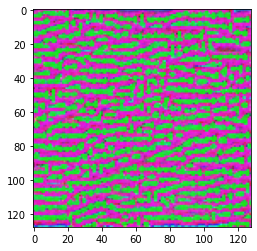

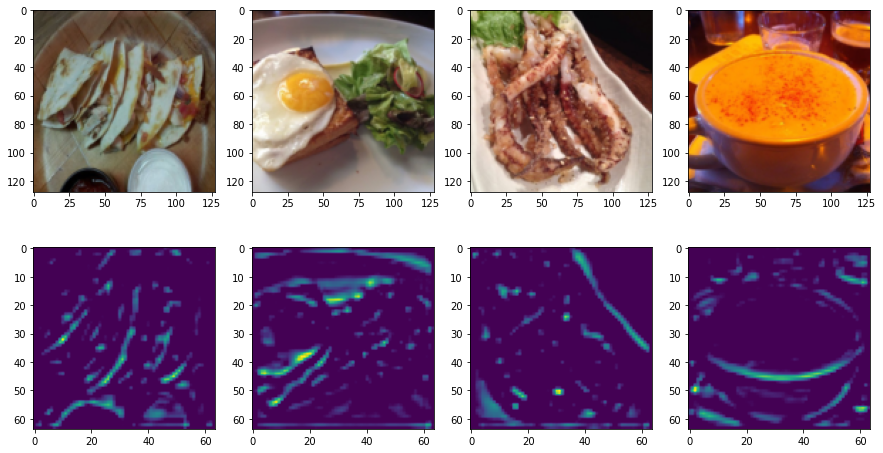

In [14]:
img_indices = [83, 4218, 4707, 8598]
images, labels = train_dataset.getbatch(img_indices)
filter_activations, filter_visualization = filter_explanation(images, model, cnn_id=15, filter_id=0, iteration=100, lr=0.1)

# plot the filter visualization
plt.imshow(normalize(filter_visualization.permute(1, 2, 0)))
plt.show()
plt.close()

# plot filter activations
fig, axs = plt.subplots(2, len(img_indices), figsize=(15, 8))
for i, img in enumerate(images):
  axs[0][i].imshow(img.permute(1, 2, 0))
for i, img in enumerate(filter_activations):
  axs[1][i].imshow(normalize(img))
plt.show()
plt.close()

- According to the lines in the 1st picture, one can infer that the 0th filter of the 15th layer CNN may try to recognize some lines or even the object boundary
- By showing a bunch of contrasting lines to the filter, it will feel that many boundaries can be activated

# Task 3: Lime
- There is a package making the Lime method very easy.
- We only need to implement two functions.

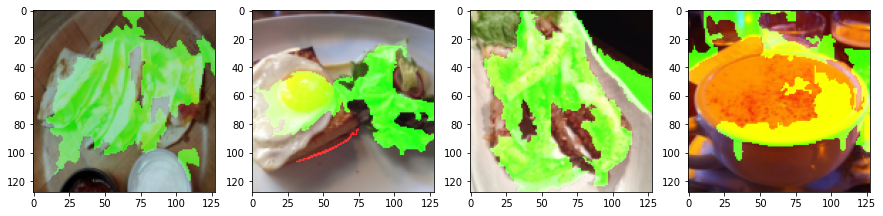

In [15]:
def predict(input):
    # input: numpy array, (batches, height, width, channels)                                                                                                                                                     
    
    model.eval()                                                                                                                                                             
    input = torch.FloatTensor(input).permute(0, 3, 1, 2)                                                 
    # transfer the input to PyTorch tensor
    # the dim should be (batches, channels, height, width)

    output = model(input.cuda())                                                                                                                                             
    return output.detach().cpu().numpy()                                                                                                                              
                                                                                                                                                                             
def segmentation(input):
    # cut the image into 100 pieces by the `segmentation` method
                                    
    return slic(input, n_segments=100, compactness=1, sigma=1)                                                                                                              
                                                                                                                                                                             
img_indices = [83, 4218, 4707, 8598]
images, labels = train_dataset.getbatch(img_indices)
fig, axs = plt.subplots(1, 4, figsize=(15, 8))                                                                                                                                                                 
np.random.seed(16) # let the result reproducible

for idx, (image, label) in enumerate(zip(images.permute(0, 2, 3, 1).numpy(), labels)):                                                                                                                                             
    x = image.astype(np.double) # numpy array is needed for lime

    explainer = lime_image.LimeImageExplainer()                                                                                                                              
    explaination = explainer.explain_instance(image=x, classifier_fn=predict, segmentation_fn=segmentation)
    # `classifier_fn`: defines how to get the prediction by input the image to the model
    # `segmentation_fn`: dedines how to do segmentation
    # doc: https://lime-ml.readthedocs.io/en/latest/lime.html?highlight=explain_instance#lime.lime_image.LimeImageExplainer.explain_instance

    lime_img, mask = explaination.get_image_and_mask(                                                                                                                         
                                label=label.item(),                                                                                                                           
                                positive_only=False,                                                                                                                         
                                hide_rest=False,                                                                                                                             
                                num_features=11,                                                                                                                              
                                min_weight=0.05                                                                                                                              
                            )
    # transform the result from explainer to image
    # doc: https://lime-ml.readthedocs.io/en/latest/lime.html?highlight=get_image_and_mask#lime.lime_image.ImageExplanation.get_image_and_mask
    
    axs[idx].imshow(lime_img)

plt.show()
plt.close()

- As can be seen from the first three pictures below, the model recognizes the location of the food and uses this location as the basis for judgment
- The only exception is the fourth picture. It seems that the model prefers to recognize the "shape" of the bowl directly to judge that the image belongs to the soup class
- As for the contents of the bowl, it is marked in red, which means that "by looking at the bowl alone" will hinder recognition.
- When the model only looks at the yellow round shape in the bowl instead of the "bowl" itself, it may think it is other yellow round food.